# UCEC Reccurance Notebook - Model Training

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# TODO: Impliment these models
from xgboost import XGBClassifier
from sklearn.svm import SVC


from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline

from collections import Counter
import matplotlib.pyplot as plt

import joblib
import config


In [2]:
# Load training data using paths from config
X_train = joblib.load(config.X_TRAIN_PATH)
y_train = joblib.load(config.Y_TRAIN_PATH)

In [3]:
def run_random_forest_classifer():
    # Code for training Random Forest
    print("Running random forest classifier")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=1e-5)), 
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif)),
        ('clf', RandomForestClassifier(random_state=config.SEED, class_weight='balanced'))
    ])

    # Define hyperparameter grid
    param_grid = {
        'clf__n_estimators': [50, 100],
        'clf__max_depth': [5, 10, 15],
        'clf__min_samples_split': [2, 4],
        'clf__min_samples_leaf': [1, 2, 4],
        'select__k': [20, 50, 100, 500],
        'clf__max_features': ['sqrt', 'log2', 0.1]  # Reduce feature space per tree
    }
    return pipeline, param_grid


def run_svc_with_LASSO():
    # Define LASSO feature selector
    lasso_selector = SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000),
        threshold='mean'
    )

    # Define SVC classifier
    svc_clf = SVC(probability=True, class_weight='balanced', random_state=config.SEED)

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', lasso_selector),
        ('classifier', svc_clf)
    ])

    # Hyperparameter grid
    param_grid = {
        'feature_selection__estimator__C': [0.01, 0.1, 1],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }

    return pipeline, param_grid


def run_svc():

    # Define SVC classifier
    svc_clf = SVC(probability=True, class_weight='balanced', random_state=config.SEED)

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('classifier', svc_clf)
    ])

    # Hyperparameter grid
    param_grid = {
        'select__k': [20, 50, 100, 500],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }

    return pipeline, param_grid


def run_xgboost(y_train):
    # Define LASSO feature selector
    lasso_selector = SelectFromModel(
        LogisticRegression(penalty='l1', solver='saga', C=0.1, max_iter=5000),
        threshold='mean'  # or use "1e-5" to keep more
    )

    # Define XGBoost classifier
    xgb_clf = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=config.SEED,
        scale_pos_weight=(np.sum(y_train == 0) / np.sum(y_train == 1))  # ratio of negatives over positives
    )

    # Build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', lasso_selector),
        ('classifier', xgb_clf)
    ])

    

    # Hyperparameter grid (you can expand this)
    param_grid = {
        'feature_selection__estimator__C': [0.01, 0.1, 1],
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
    }
    return pipeline, param_grid


def run_logistic_regression():
    # Define the pipeline with Logistic Regression
    print("Running Logistic Regression")
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)), 
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', LogisticRegression(class_weight='balanced', random_state=config.SEED))
    ])

    # define hyperparameter grid for logistic regression
    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'select__k': [50, 100, 500, 1000]
    }
    return pipeline, param_grid

def run_logistic_regression_with_LASSO():
    print("Running Logistic Regression with LASSO")

    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.001)),
        ('scaler', StandardScaler()),
        ('select', SelectKBest(score_func=f_classif, k=1000)),
        ('clf', LogisticRegression(
            penalty='l1',
            solver='saga',
            class_weight='balanced',
            random_state=config.SEED,
            max_iter=10000,
            verbose=1
        ))
    ])

    param_grid = {
        'clf__C': [0.01, 0.1, 1, 10]  # Smaller C = more sparsity
    }

    return pipeline, param_grid

# Change which model you are using here
# pipeline, param_grid = run_random_forest_classifer()
pipeline, param_grid = run_svc()
# pipeline, param_grid = run_logistic_regression_with_LASSO()

# Set up cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.SEED)

# Grid search over pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # Or 'f1' if recurrence class is more important
    n_jobs=-1,
    verbose=3
)

# Fit pipeline on training data
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# [6416 12260 12263 12264 12392 12400 12416 12426 12431 12526 12527 12892 13602 14340 16428 18227 20043] are constant.

Fitting 3 folds for each of 48 candidates, totalling 144 fits


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [3] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Looking at the hyperparameter tuning

In [4]:
print("Overall best params:", grid_search.best_params_, "\n")

# Retrieve the results from grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores for each parameter combination
mean_test_scores = cv_results['mean_test_score']

# Extract the standard deviation of test scores for each parameter combination
std_test_scores = cv_results['std_test_score']

# Extract the parameter settings for each run
params = cv_results['params']

# Print the AUC-ROC scores for each parameter combination
for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Parameters: {param}")
    print(f"Mean AUC-ROC: {mean:.4f}")
    print(f"Standard Deviation: {std:.4f}")
    print("-" * 30)


Overall best params: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'select__k': 500} 

Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'select__k': 20}
Mean AUC-ROC: 0.6363
Standard Deviation: 0.0542
------------------------------
Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'select__k': 50}
Mean AUC-ROC: 0.6188
Standard Deviation: 0.0530
------------------------------
Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'select__k': 100}
Mean AUC-ROC: 0.6111
Standard Deviation: 0.0095
------------------------------
Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'linear', 'select__k': 500}
Mean AUC-ROC: 0.5690
Standard Deviation: 0.0177
------------------------------
Parameters: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'select__

In [5]:
# # Save the best estimator from GridSearchCV
# joblib.dump(best_model, config.SVC_MODEL_PATH) # change the path depending on the model
# print("Model saved to:", config.SVC_MODEL_PATH)


  this got overfitting but not 100% negative prediction (used k = 3)
Overall best params: {'clf__max_depth': 5, 'clf__min_samples_split': 4, 'clf__n_estimators': 50, 'select__k': 100} 

  this got 100% Negative prediction (used k = 7)
Overall best params: {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 50, 'select__k': 1000} 

  this got AUC-ROC of 0.575 (using k = 3)
Overall best params: {'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'select__k': 100} 


Overall best params: {'clf__max_depth': 5, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100, 'select__k': 100} 

  this what I got when I split 40% of data into the test, this one did really poorly (AUC-ROC = 0.49)
Overall best params: {'clf__max_depth': 10, 'clf__max_features': 0.1, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 50, 'select__k': 500} 

FOR LOGISTIC REGRESSION:
  AUC-ROC of 0.69
Overall best params: {'clf__C': 0.01, 'select__k': 50} 

for CVS (no LASSO):
Overall best params: {'classifier__C': 0.1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'select__k': 500} 
Mean AUC-ROC: 0.6541
Standard Deviation: 0.0140
BUT, no testing data got: 

True Positives (TP): 14
False Positives (FP): 35
True Negatives (TN): 47
False Negatives (FN): 3
AUC-ROC Score: 0.6984



Analyzing the prediction of the training data

True Positives (TP): 56
False Positives (FP): 126
True Negatives (TN): 203
False Negatives (FN): 11
AUC-ROC Score: 0.7264


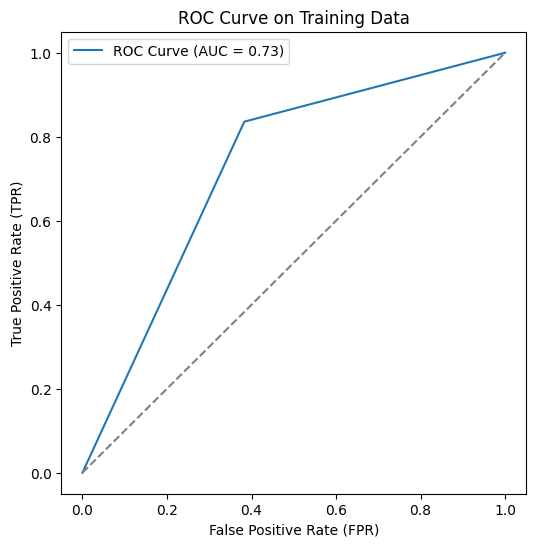

In [6]:
y_train_pred = best_model.predict(X_train)

cm_test = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_train, y_train_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_train, y_train_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Training Data")
plt.legend()
plt.show()

Analyzing the performace on the training data

In [7]:
y_test_pred = best_model.predict(X_test)

cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Compute the AUC-ROC score
roc_auc = roc_auc_score(y_test, y_test_pred)

# Print the AUC-ROC score
print(f"AUC-ROC Score: {roc_auc:.4f}")

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_pred)

# Plot the ROC Curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Testing Data")
plt.legend()
plt.show()

NameError: name 'X_test' is not defined

In [ ]:
# Extract the fitted steps
coefficients = best_model.named_steps['clf'].coef_.flatten()


# Pair each selected feature with its coefficient
feature_weights = list(zip(feature_names, coefficients))

# Sort features by absolute coefficient value (importance)
sorted_features = sorted(feature_weights, key=lambda x: abs(x[1]), reverse=True)

# Print top 20 most influential features
print("Top 20 features by absolute weight:")
for feature, weight in sorted_features[:20]:
    print(f"{feature}: {weight:.4f}")

non_zero_count = np.sum(coefficients != 0)
print(f"\nNumber of non-zero coefficients: {non_zero_count} out of {len(coefficients)}")

KeyError: 'clf'